# Noise Detection

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
from Constants import Constants

In [2]:
# define the directories
dataset_dir = os.path.join(Constants.PATH_NOISE_DATASET_RAW)
just_saturated_dataset_dir = os.path.join(dataset_dir,"just_saturated")
over_saturated_dataset_dir = os.path.join(dataset_dir,"over_saturated")
under_saturated_dataset_dir = os.path.join(dataset_dir,"under_saturated")

# pick a sample image
# sample_image = os.path.join(just_saturated_dataset_dir,"just_saturated_0.bmp")
# sample_image = os.path.join(over_saturated_dataset_dir,"over_saturated_light_level_1_0.bmp")
# sample_image = os.path.join(over_saturated_dataset_dir,"test.bmp")
sample_image = os.path.join(under_saturated_dataset_dir,"under_saturated_light_level_1_3.bmp")

sample_image = Constants.LOCAL_FILE_PATH_BMP

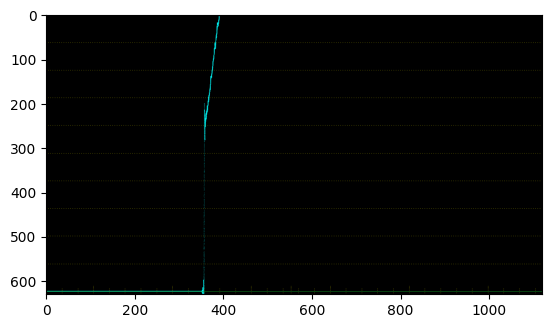

ValueError: min() arg is an empty sequence

In [3]:
# Read image
img = cv2.imread(sample_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# select region of interest and display it
roi = img[150:780,400:1520]
plt.imshow(roi)
plt.show()

# get red and green pixels
height,width = roi.shape[:2]
red_pixels = [(x, y) for x in range(width) for y in range(height) if roi[y, x, 0] > roi[y, x, 1] and roi[y, x, 0] > roi[y, x, 2]]
green_pixels = [(x, y) for x in range(width) for y in range(height) if roi[y, x, 1] > roi[y, x, 0] and roi[y, x, 1] > roi[y, x, 2]]

# function to get red pixels within or outside the 3-pixel range of the green pixels
def get_red_pixels_relative_to_green(red_pixels, green_pixels, within_range):
    red_pixels_relative = []
    for green_x, green_y in green_pixels:
        for red_x, red_y in red_pixels:
            if within_range == ((green_x - 3 <= red_x <= green_x + 3) and (green_y - 3 <= red_y <= green_y + 3)):
                red_pixels_relative.append((red_x, red_y))
    return red_pixels_relative
# Get peak of the red curve (lowest y value)
red_peak = min(red_pixels, key=lambda coord: coord[1])

# Get corresponding point on the green line (same x value)
green_corresponding = [coord for coord in green_pixels if coord[0] == red_peak[0]]

if green_corresponding:
    # if there's more than one point with the same x value, choose the one closest to the red peak.
    green_corresponding = min(green_corresponding, key=lambda coord: abs(coord[1] - red_peak[1]))
else:
    green_corresponding = None

print("Red peak: ", red_peak)
print("Green corresponding: ", green_corresponding)
if green_corresponding is not None:
    # get the 50 pixels around the center of green pixels
    green_pixels_around_center = [(x, y) for x, y in green_pixels if abs(x - green_corresponding[0]) <= 25 and abs(y - green_corresponding[1]) <= 25]

    # get red pixels near and far from green
    red_pixels_near_green = get_red_pixels_relative_to_green(red_pixels, green_pixels_around_center, within_range=True)
    red_pixels_far_green = get_red_pixels_relative_to_green(red_pixels, green_pixels_around_center, within_range=False)

    # plot in the same graph
    plt.scatter(*zip(*red_pixels), c='r', s=1)
    plt.scatter(*zip(*green_pixels_around_center), c='g', s=1)
    if red_pixels_near_green:
        plt.scatter(*zip(*red_pixels_near_green), c='b', s=1)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    # check if there are red pixels both above and below the green pixels within or outside a 3-pixel range
    check_red_pixels_relative_to_green = lambda red_pixels_relative: (any(red_y < green_corresponding[1] for red_x, red_y in red_pixels_relative),
                                                                    any(red_y > green_corresponding[1] for red_x, red_y in red_pixels_relative))

    red_pixels_above_near, red_pixels_below_near = check_red_pixels_relative_to_green(red_pixels_near_green)
    red_pixels_above_far, red_pixels_below_far = check_red_pixels_relative_to_green(red_pixels_far_green)

    num_red_pixels_above = len([coord for coord in red_pixels_near_green if coord[1] < green_corresponding[1]])
    num_red_pixels_below = len([coord for coord in red_pixels_near_green if coord[1] > green_corresponding[1]])


    # calculate the ratio
    # add a small number to the denominator to avoid division by zero
    ratio = num_red_pixels_above / (num_red_pixels_below + 1e-10)

    # define the acceptable range for the ratio
    lower_bound = 0.7
    upper_bound = 1.3


    # classify the image
    if red_pixels_above_near and red_pixels_below_near:
            # classify the image
        if lower_bound <= ratio <= upper_bound:
            print("The image is just correct")
        elif ratio > upper_bound:
            print("The image is too high")
        elif ratio < lower_bound:
            print("The image is too low")
        else:
            print("The image does not meet any of the criteria")
    elif (red_pixels_above_near and not red_pixels_below_near) or (not red_pixels_near_green and red_pixels_above_far):
        print("The image is too high")
    elif (not red_pixels_above_near and red_pixels_below_near) or (not red_pixels_near_green and red_pixels_below_far):
        print("The image is too low")
    else:
        print("The image does not meet any of the criteria")